# Import

In [1]:
import glob
import numpy as np
import pandas as pd
import sklearn.cluster
import sklearn.preprocessing
import sklearn.decomposition
import matplotlib.pyplot as plt

# Settings

In [2]:
mod = "P"
presenze = 10
# years = ["2022_23", "2023_24", "2024_25"]
years = ["2023_24", "2024_25"]
# years = ["2023_24"]
filepaths = list()
for year in years:
    filepaths += glob.glob(f"./data/*{year}*.xlsx") 

In [3]:
filepaths

['./data/Statistiche_Fantacalcio_Stagione_2023_24.xlsx',
 './data/Statistiche_Fantacalcio_Stagione_2023_24_Italia.xlsx',
 './data/Statistiche_Fantacalcio_Stagione_2023_24_Statistico.xlsx',
 './data/Statistiche_Fantacalcio_Stagione_2024_25.xlsx',
 './data/Statistiche_Fantacalcio_Stagione_2024_25_Italia.xlsx',
 './data/Statistiche_Fantacalcio_Stagione_2024_25_Statistico.xlsx']

# Prepare dataframe

In [4]:
df_list = list()
for filepath in filepaths:
    df = pd.read_excel(filepath, header=1)
    df = df[df.R == mod]
    if "2024_25" not in filepath:
        # Filtro presenze no su anno corrente
        pres = presenze
    else:
        pres = 2
    df = df[df.Pv >= pres]
    df_list.append(df)
df = pd.concat(df_list)

### Get only Fm, Mv, Nome and Pv

In [5]:
df_reduced = df[["Fm", "Mv", "Nome", "Pv"]].copy()
bonus = np.abs(df.Mv - df.Fm)
df_reduced["Bonus"] = bonus
df_reduced.index = df.Nome
del df_reduced["Nome"], df_reduced["Fm"]

### Remove players no more in serie A

In [6]:
filpath_last = "2024_25"
filepaths = glob.glob(f"./data/*{filpath_last}.xlsx")
df_last_year = pd.read_excel(filepaths[0], header=1)
df_last_year.index = df_last_year["Nome"]
players_to_remove = set(df_reduced.index).difference(set(df_last_year.index))

### Compute mean over different sources

In [7]:
to_group = ["Bonus", "Mv", "Pv"]
by_row_index = df_reduced[to_group].groupby(df_reduced[to_group].index)
df_means = by_row_index.mean()

In [8]:
df_means.drop(players_to_remove, inplace=True)

# Scaling

In [9]:
df_means.head(2)

,Bonus,Mv,Pv
Nome,,,
Caprile,1.040,6.273333,23.0
Carnesecchi,1.945,6.276667,14.5


In [10]:
scaler = sklearn.preprocessing.StandardScaler()
df_reduced_min_max = scaler.fit_transform(df_means.drop(axis=1, columns=["Pv"]))
pca = sklearn.decomposition.PCA(n_components=2)
X = pca.fit_transform(df_reduced_min_max)
df_X = pd.DataFrame(X)
df_X.index = df_means.index

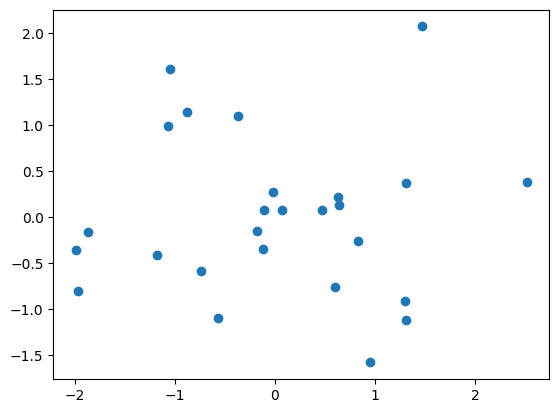

In [11]:
fig, ax = plt.subplots(1, 1)
ax.scatter(df_X[0], df_X[1])

# Outliers

In [12]:
# IQR
# Calculate the upper and lower limits
Q1 = df_X[0].quantile(0.25)
Q3 = df_X[0].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

# Create arrays of Boolean values indicating the outlier rows
upper_array_0 = np.where(df_X[0] >= upper)[0]
lower_array_0 = np.where(df_X[0] <= lower)[0]

Q1 = df_X[1].quantile(0.25)
Q3 = df_X[1].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

# Create arrays of Boolean values indicating the outlier rows
upper_array_1 = np.where(df_X[1] >= upper)[0]
lower_array_1 = np.where(df_X[1] <= lower)[0]

# Removing the outliers
to_drop = df_X.index.values[np.concatenate((upper_array_0, 
                                            lower_array_0,
                                            upper_array_1,
                                            lower_array_1))]
df_X_no_outliers = df_X.drop(index=to_drop)

# Clustering

In [13]:
kmeans = sklearn.cluster.KMeans(n_clusters=3, random_state=0, n_init="auto").fit(df_X_no_outliers)
labels = kmeans.predict(df_X)

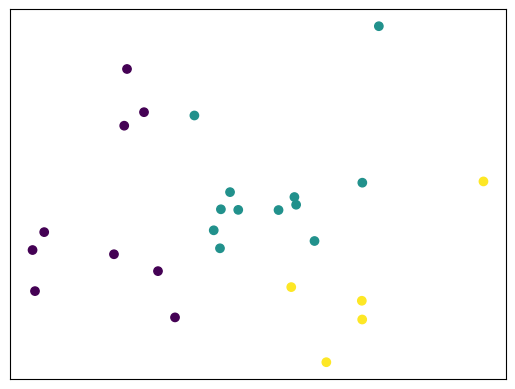

In [14]:
fig, ax = plt.subplots(1, 1)
ax.scatter(df_X[0], df_X[1], c=labels)
ax.set_xticks([])
ax.set_yticks([]);

In [15]:
pv_anno_corrente = [df_last_year.loc[index].Pv for index in df_means.index]
mv_anno_corrente = [df_last_year.loc[index].Mv for index in df_means.index]
fm_anno_corrente = [df_last_year.loc[index].Fm for index in df_means.index]
squadra = [df_last_year.loc[index].Squadra for index in df_means.index]
df_means["Fm-2024_25"] = fm_anno_corrente
df_means["Pv-2024_25"] = pv_anno_corrente
df_means["Squadra"] = squadra
df_means["Fascia"] = labels

# Output

In [16]:
df_means.sort_values("Fascia", inplace=True)

In [17]:
df_means.to_html(f"./output/{mod}-{presenze}.html")

In [18]:
str_out = f"./output/{mod}-{presenze}.html"
print(f"See {str_out}")

See ./output/P-10.html
